# CPSC 599.83 - Project 1.2

*Tyler Gillson - 10170105*

In [208]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<span style="color:red">The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</span>''')

## Analysis Questions

1.	Of the 65 features in the transformed data, how independent are they from one another? Can some of them be removed?
2.  Which combinations of features and visualization format can best illuminate the overlap between user profiles?	
3.	On average, how much variance occurs within each of the feature groups? What about in the set of all registration and verification data obtained from individual users?
4.	Do clear clusters of user profiles exist? If so, can they be given meaningful names?
5.	How widely (or narrowly) are the user profiles dispersed within the entire 65-dimensional feature space?
6.	How much of the variation in a given circle vector can be attributed to device type?

In [209]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm
from sklearn import preprocessing

import plotly.figure_factory as ff
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

In [210]:
pd.options.display.max_columns = 65
pd.options.display.max_rows = 20

In [211]:
# Import transformed data from project 1.1:
all_data = pd.read_csv('transformed_data.csv', delimiter='\t')
dac_index = pd.read_csv('index.csv')

### Q1: Of the 65 features in the transformed data, how independent are they from one another? Can some of them be removed?

Text(0.5,1,'Feature Correlation Heatmap')

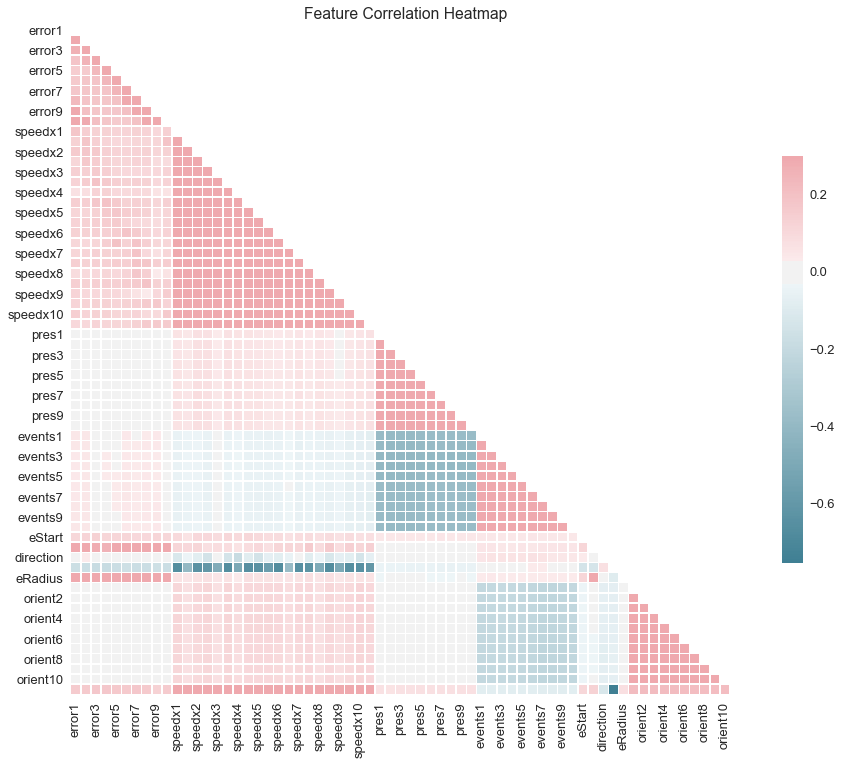

In [212]:
# Reference: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Compute the correlation matrix
corr = all_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style='white', color_codes=True, font_scale=1.3)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Feature Correlation Heatmap')

The correlation matrix heatmap illustrates that, for the most part, each feature is more strongly correlated with other features from within its feature group than with features from other groups. This confirms that the feature groups are logical and does not indicate that any particular feature stands out as a candidate for removal.

In [213]:
# Calculate the sum of all correlations for each feature:
row_sums = []
for index, row in corr.iterrows():
    row_sum = sum([abs(x) for x in row])
    row_sums.append(row_sum)

corr['row_sum'] = row_sums

In [214]:
feature_groups = [index[:3] for index in corr]
speeds = ['spx' if i % 2==0 else 'spy' for i in range(0,20)]
feature_groups[10:30] = speeds
corr['feature_group'] = feature_groups

In [215]:
corr['xaxis'] = ['F'+str(x) for x in range(1,67)]

In [216]:
# Build a dictionary of feature group <--> color mappings: 
feature_group_keys = [val for val in corr['feature_group'].unique()]
my_palette = sns.color_palette("muted", 11)
palette_dir = dict(zip(feature_group_keys, my_palette))

In [217]:
sns.set(rc={'axes.labelsize':20, 'axes.titlesize':30})
sns.set_style('white')

[Text(0,0.5,'Total Correlation'),
 Text(0.5,0,'Feature'),
 Text(0.5,1,'Total Correlation by Feature Group')]

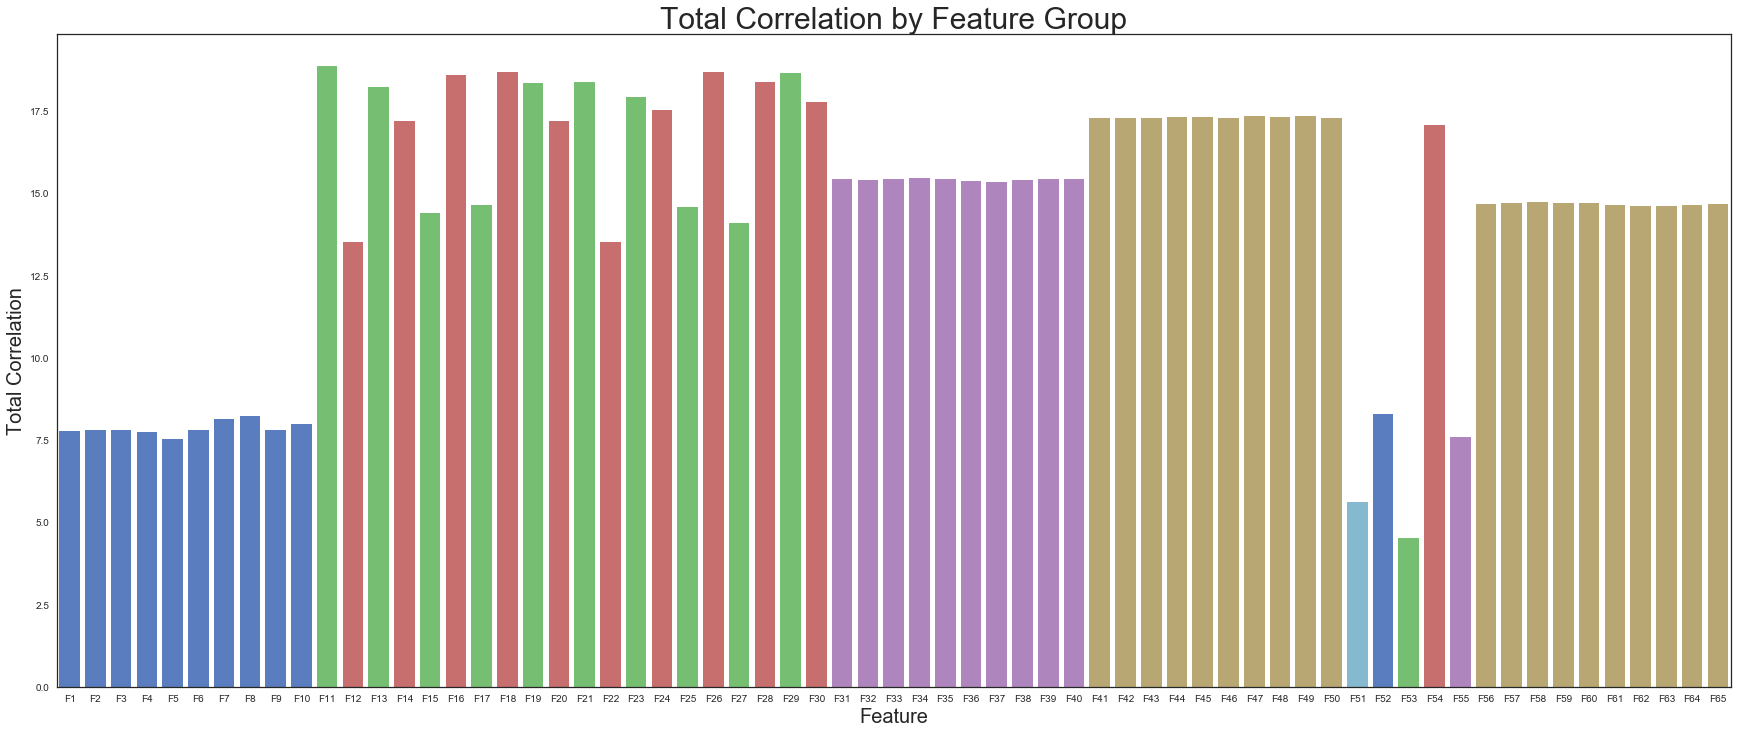

In [218]:
corr['features'] = corr.index
f, ax = plt.subplots(figsize=(30, 12))
_ = sns.barplot(data=corr.drop(columns=['features','row_sum','feature_group','xaxis']),
                x=corr['xaxis'][0:-1],
                y=corr['row_sum'][0:-1],
                palette=corr['feature_group'].map(palette_dir))
ax.set(xlabel='Feature',
       ylabel='Total Correlation',
       title='Total Correlation by Feature Group')

By presenting each feature's total correlation by feature group, the inter-group consistency is further emphasized. The features within each group have highly similar total correlations due to roughly equivalent inter-group correlation values, coupled with negligible intra-group correlation values.

#### Reduce speed x & y to speed z and re-visualize:

In [219]:
import math

def reduce_features(df):
    all_zvectors = []
    
    for index, row in df.iterrows():
        zvectors = [math.sqrt(math.pow(row['speedx'+str(i)],2) +
                              math.pow(row['speedy'+str(i)],2)) for i in range(1,11)]
        all_zvectors.append(zvectors)

    all_zvectors_df = pd.DataFrame(all_zvectors, 
        columns=['spz1','spz2','spz3','spz4','spz5','spz6','spz7','spz8','spz9','spz10'])

    df = df.drop(df.loc[:, 'speedx1':'speedy10'], axis=1)
    df = pd.concat([all_zvectors_df, df], axis=1)
    return df

In [220]:
all_data2 = reduce_features(all_data)

In [221]:
# Re-order all_data:
all_data2 = pd.concat([all_data2['ID'], all_data2.loc[:, 'error1':'error10'], all_data2.loc[:, 'spz1':'spz10'], all_data2.loc[:, 'pres1':'orient10']], axis=1)

In [222]:
corr2 = all_data2.corr()

In [437]:
#mask = np.zeros_like(corr2, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True
#sns.set(style='white', color_codes=True, font_scale=1.3)
#f, ax = plt.subplots(figsize=(15, 15))
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
#_ = sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.title('Feature Correlation Heatmap')

In [224]:
# Calculate the sum of all correlations for each feature:
row_sums = []
for index, row in corr2.iterrows():
    row_sum = sum([abs(x) for x in row])
    row_sums.append(row_sum)

corr2['row_sum'] = row_sums

In [225]:
feature_groups = [index[:3] for index in corr2.index]
corr2['feature_group'] = feature_groups

In [226]:
corr2['xaxis'] = ['F'+str(x) for x in range(1,56)]

In [227]:
# Build a dictionary of feature group <--> color mappings: 
feature_group_keys = [val for val in corr2['feature_group'].unique()]
my_palette = sns.color_palette("muted", 11)
palette_dir = dict(zip(feature_group_keys, my_palette))

In [228]:
sns.set(rc={'axes.labelsize':20, 'axes.titlesize':30})
sns.set_style('white')

[Text(0,0.5,'Total Correlation'),
 Text(0.5,0,'Feature'),
 Text(0.5,1,'Total Correlation by Feature Group')]

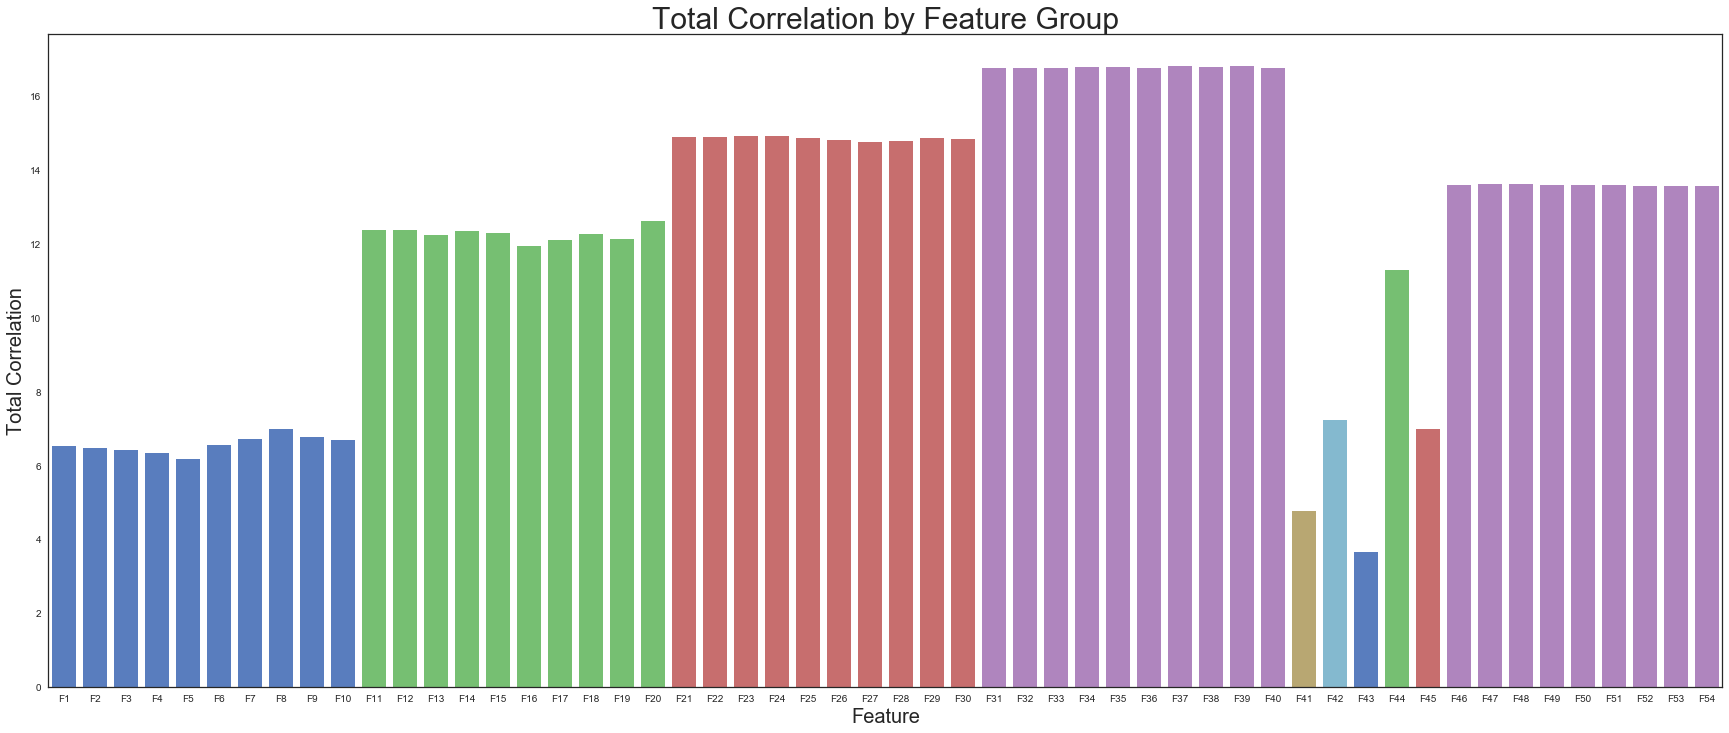

In [229]:
corr2['features'] = corr2.index
f, ax = plt.subplots(figsize=(30, 12))
_ = sns.barplot(data=corr2.drop(columns=['features','row_sum','feature_group','xaxis']),
                x=corr2['xaxis'][0:-1],
                y=corr2['row_sum'][0:-1],
                palette=corr2['feature_group'].map(palette_dir))
ax.set(xlabel='Feature',
       ylabel='Total Correlation',
       title='Total Correlation by Feature Group')

After collapsing the speed x and speed y data into a "speed z" value, the differences in total correlation across axes are smoothed out.

#### Reduce feature groups and re-calculate correlation matrix


In [230]:
all_data = all_data.drop(columns='row_sum')

In [231]:
err_avg = all_data.loc[:,'error1':'error10'].mean(axis=1)
sx_avg = all_data.loc[:,'speedx1':'speedx10':2].mean(axis=1)
sy_avg = all_data.loc[:,'speedy1':'speedy10':2].mean(axis=1)
p_avg = all_data.loc[:,'pres1':'pres10'].mean(axis=1)
ev_avg = all_data.loc[:,'events1':'events10'].mean(axis=1)
o_avg = all_data.loc[:,'orient1':'orient10'].mean(axis=1)
        
all_data['error_avg'] = err_avg
all_data['speedx_avg'] = sx_avg
all_data['speedy_avg'] = sy_avg
all_data['pressure_avg'] = p_avg
all_data['events_avg'] = ev_avg
all_data['orientation_avg'] = o_avg

In [232]:
reduced_data = pd.concat([all_data['ID'], all_data.loc[:, 'eStart':'eRadius'], all_data.loc[:, 'error_avg':]], axis=1)

Text(0.5,1,'Feature Correlation Heatmap')

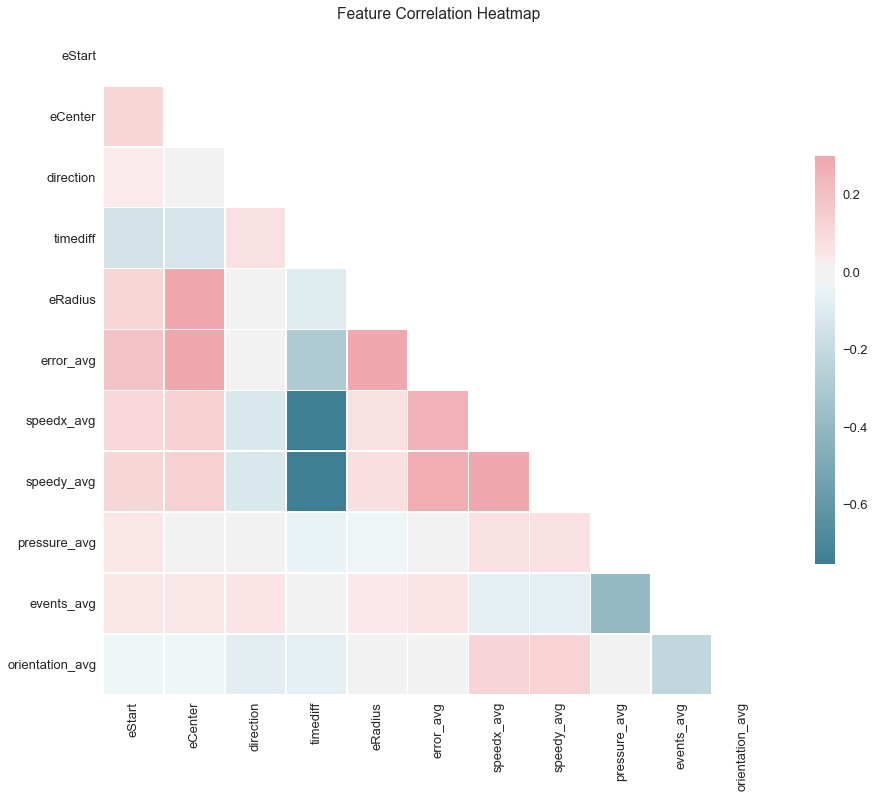

In [233]:
corr3 = reduced_data.corr()
mask = np.zeros_like(corr3, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style='white', color_codes=True, font_scale=1.3)
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.heatmap(corr3, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Heatmap')

After reducing each of the feature groups to an average value, it is clear that error and speed have slightly positive mutual correlations, but not to a striking degree. However, it is now very clear that timediff is tightly bound with the speed x and speed y feature groups. Therefore it is possible that the timediff feature could be removed from the dataset without considerably impacting the system's accuracy.

### Q2: Which combinations of features and visualization format can best illuminate the overlap between user profiles?

Obtaining insight into the nature of the overlap between user profiles will enable tuning of the authentication system; as specific features can be assigned weights according to how effective they are at distinguishing one user from another. I started off by producing a parallel coordinates plot of the entire raw dataset in order to see if any particular features or feature groups would stand out.

In [234]:
all_data_grouped = all_data2.groupby('ID', as_index=False, sort=False).mean()

In [235]:
def encode_labels(df, col):
    le = preprocessing.LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [236]:
encode_labels(all_data_grouped, 'ID')

In [237]:
# Use scikitlearn's Robust Scaler to normalize all the grouped data:
rs = preprocessing.RobustScaler(with_centering=False)
data_scaled = rs.fit_transform(all_data_grouped.drop(columns=['ID']))
all_data_scaled = pd.DataFrame(data=data_scaled)
all_data_scaled = pd.concat([all_data_grouped['ID'], all_data_scaled], axis=1)
all_data_scaled.columns = all_data_grouped.columns

In [238]:
def print_min_max(df):
    for col in df.columns:
        print(col, "[" + str(df[col].min()) + "," + str(df[col].max()) + "]")

In [239]:
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

#### Raw Data:

In [240]:
# Parallel coordinates plot for all of the unscaled data:
data = [
    go.Parcoords(
        line = dict(color = all_data_grouped['ID'],
                   colorscale = 'Jet',
                   showscale = False,
                   reversescale = False,
                   cmin = 0,
                   cmax = 200),
        hoverinfo = all_data_grouped['ID'],
        dimensions = list([
            # Other:
            dict(range = [-1,1],
                 constraintrange = [0,1],
                 label = 'D', values = all_data_grouped['direction']),
            dict(range = [2,24],
                 label = 'eS', values = all_data_grouped['eStart']),
            dict(range = [5,18],
                 label = 'eC', values = all_data_grouped['eCenter']),
            dict(range = [1,16],
                 label = 'eR', values = all_data_grouped['eRadius']),
            dict(range = [0.002,0.032],
                 label = 'TD', values = all_data_grouped['timediff']),
            
            # Error:
            dict(range = [3,26],
                 label = 'E1', values = all_data_grouped['error1']),
            dict(range = [3,26],
                 label = 'E2', values = all_data_grouped['error2']),
            dict(range = [3,26],
                 label = 'E3', values = all_data_grouped['error3']),
            dict(range = [3,26],
                 label = 'E4', values = all_data_grouped['error4']),
            dict(range = [3,26],
                 label = 'E5', values = all_data_grouped['error5']),
            dict(range = [3,26],
                 label = 'E6', values = all_data_grouped['error6']),
            dict(range = [3,26],
                 label = 'E7', values = all_data_grouped['error7']),
            dict(range = [3,26],
                 label = 'E8', values = all_data_grouped['error8']),
            dict(range = [3,26],
                 label = 'E9', values = all_data_grouped['error9']),
            dict(range = [3,26],
                 label = 'E10', values = all_data_grouped['error10']),
            
            # Speed Z:
            dict(range = [354,6530],
                 label = 'Z1', values = all_data_grouped['spz1']),
            dict(range = [354,6530],
                 label = 'Z2', values = all_data_grouped['spz2']),
            dict(range = [354,6530],
                 label = 'Z3', values = all_data_grouped['spz3']),
            dict(range = [354,6530],
                 label = 'Z4', values = all_data_grouped['spz4']),
            dict(range = [354,6530],
                 label = 'Z5', values = all_data_grouped['spz5']),
            dict(range = [354,6530],
                 label = 'Z6', values = all_data_grouped['spz6']),
            dict(range = [354,6530],
                 label = 'Z7', values = all_data_grouped['spz7']),
            dict(range = [354,6530],
                 label = 'Z8', values = all_data_grouped['spz8']),
            dict(range = [354,6530],
                 label = 'Z9', values = all_data_grouped['spz9']),
            dict(range = [354,6530],
                 label = 'Z10', values = all_data_grouped['spz10']),
            
            # Pressure:
            dict(range = [0,1],
                 label = 'P1', values = all_data_grouped['pres1']),
            dict(range = [0,1],
                 label = 'P2', values = all_data_grouped['pres2']),
            dict(range = [0,1],
                 label = 'P3', values = all_data_grouped['pres3']),
            dict(range = [0,1],
                 label = 'P4', values = all_data_grouped['pres4']),
            dict(range = [0,1],
                 label = 'P5', values = all_data_grouped['pres5']),
            dict(range = [0,1],
                 label = 'P6', values = all_data_grouped['pres6']),
            dict(range = [0,1],
                 label = 'P7', values = all_data_grouped['pres7']),
            dict(range = [0,1],
                 label = 'P8', values = all_data_grouped['pres8']),
            dict(range = [0,1],
                 label = 'P9', values = all_data_grouped['pres9']),
            dict(range = [0,1],
                 label = 'P10', values = all_data_grouped['pres10']),
            
            # Events:
            dict(range = [0,0.9],
                 label = 'V1', values = all_data_grouped['events1']),
            dict(range = [0,0.9],
                 label = 'V2', values = all_data_grouped['events2']),
            dict(range = [0,0.9],
                 label = 'V3', values = all_data_grouped['events3']),
            dict(range = [0,0.9],
                 label = 'V4', values = all_data_grouped['events4']),
            dict(range = [0,0.9],
                 label = 'V5', values = all_data_grouped['events5']),
            dict(range = [0,0.9],
                 label = 'V6', values = all_data_grouped['events6']),
            dict(range = [0,0.9],
                 label = 'V7', values = all_data_grouped['events7']),
            dict(range = [0,0.9],
                 label = 'V8', values = all_data_grouped['events8']),
            dict(range = [0,0.9],
                 label = 'V9', values = all_data_grouped['events9']),
            dict(range = [0,0.9],
                 label = 'V10', values = all_data_grouped['events10']),
            
            # Orients:
            dict(range = [0,360],
                 label = 'O1', values = all_data_grouped['orient1']),
            dict(range = [0,360],
                 label = 'O2', values = all_data_grouped['orient2']),
            dict(range = [0,360],
                 label = 'O3', values = all_data_grouped['orient3']),
            dict(range = [0,360],
                 label = 'O4', values = all_data_grouped['orient4']),
            dict(range = [0,360],
                 label = 'O5', values = all_data_grouped['orient5']),
            dict(range = [0,360],
                 label = 'O6', values = all_data_grouped['orient6']),
            dict(range = [0,360],
                 label = 'O7', values = all_data_grouped['orient7']),
            dict(range = [0,360],
                 label = 'O8', values = all_data_grouped['orient8']),
            dict(range = [0,360],
                 label = 'O9', values = all_data_grouped['orient9']),
            dict(range = [0,360],
                 label = 'O10', values = all_data_grouped['orient10']),          
        ])
    )
]

py.iplot(data, filename = 'parcoords_all_raw')

The difference in range across the features made the plot difficult to interpret. Additionally, the overlapping labels were extremely busy and confusing. So I used scikitlearn's RobustScaler to convert all of the data into the same range. Doing so removed each feature's median but preserved the data's quantile range. This method preserves the underlying statistical distribution of each feature, while simultaneously normalizing the data.

#### Scaled Data:

In [241]:
# Parallel coordinates plot for all of the scaled data:
data = [
    go.Parcoords(
        line = dict(color = all_data_scaled['ID'],
                   colorscale = 'Jet',
                   showscale = False,
                   reversescale = False,
                   cmin = 0,
                   cmax = 200),
        hoverinfo = all_data_scaled['ID'],
        dimensions = list([
            # Other:
            dict(range = [-1,10],
                 constraintrange = [1,1.5],
                 label = 'eS', values = all_data_scaled['eStart']),
            dict(range = [-1,10],
                 label = 'eC', values = all_data_scaled['eCenter']),
            dict(range = [-1,10],
                 label = 'eR', values = all_data_scaled['eRadius']),
            dict(range = [-1,10],
                 label = 'D', values = all_data_scaled['direction']),
            dict(range = [-1,10],
                 label = 'TD', values = all_data_scaled['timediff']), 
            
            # Error:
            dict(range = [-1,10],
                 label = 'E1', values = all_data_scaled['error1']),
            dict(range = [-1,10],
                 label = 'E2', values = all_data_scaled['error2']),
            dict(range = [-1,10],
                 label = 'E3', values = all_data_scaled['error3']),
            dict(range = [-1,10],
                 label = 'E4', values = all_data_scaled['error4']),
            dict(range = [-1,10],
                 label = 'E5', values = all_data_scaled['error5']),
            dict(range = [-1,10],
                 label = 'E6', values = all_data_scaled['error6']),
            dict(range = [-1,10],
                 label = 'E7', values = all_data_scaled['error7']),
            dict(range = [-1,10],
                 label = 'E8', values = all_data_scaled['error8']),
            dict(range = [-1,10],
                 label = 'E9', values = all_data_scaled['error9']),
            dict(range = [-1,10],
                 label = 'E10', values = all_data_scaled['error10']),
            
            # Speed Z:
            dict(range = [-1,10],
                 label = 'Z1', values = all_data_scaled['spz1']),
            dict(range = [-1,10],
                 label = 'Z2', values = all_data_scaled['spz2']),
            dict(range = [-1,10],
                 label = 'Z3', values = all_data_scaled['spz3']),
            dict(range = [-1,10],
                 label = 'Z4', values = all_data_scaled['spz4']),
            dict(range = [-1,10],
                 label = 'Z5', values = all_data_scaled['spz5']),
            dict(range = [-1,10],
                 label = 'Z6', values = all_data_scaled['spz6']),
            dict(range = [-1,10],
                 label = 'Z7', values = all_data_scaled['spz7']),
            dict(range = [-1,10],
                 label = 'Z8', values = all_data_scaled['spz8']),
            dict(range = [-1,10],
                 label = 'Z9', values = all_data_scaled['spz9']),
            dict(range = [-1,10],
                 label = 'Z10', values = all_data_scaled['spz10']),
            
            # Pressure:
            dict(range = [-1,10],
                 label = 'P1', values = all_data_scaled['pres1']),
            dict(range = [-1,10],
                 label = 'P2', values = all_data_scaled['pres2']),
            dict(range = [-1,10],
                 label = 'P3', values = all_data_scaled['pres3']),
            dict(range = [-1,10],
                 label = 'P4', values = all_data_scaled['pres4']),
            dict(range = [-1,10],
                 label = 'P5', values = all_data_scaled['pres5']),
            dict(range = [-1,10],
                 label = 'P6', values = all_data_scaled['pres6']),
            dict(range = [-1,10],
                 label = 'P7', values = all_data_scaled['pres7']),
            dict(range = [-1,10],
                 label = 'P8', values = all_data_scaled['pres8']),
            dict(range = [-1,10],
                 label = 'P9', values = all_data_scaled['pres9']),
            dict(range = [-1,10],
                 label = 'P10', values = all_data_scaled['pres10']),
            
            # Events:
            dict(range = [-1,10],
                 label = 'V1', values = all_data_scaled['events1']),
            dict(range = [-1,10],
                 label = 'V2', values = all_data_scaled['events2']),
            dict(range = [-1,10],
                 label = 'V3', values = all_data_scaled['events3']),
            dict(range = [-1,10],
                 label = 'V4', values = all_data_scaled['events4']),
            dict(range = [-1,10],
                 label = 'V5', values = all_data_scaled['events5']),
            dict(range = [-1,10],
                 label = 'V6', values = all_data_scaled['events6']),
            dict(range = [-1,10],
                 label = 'V7', values = all_data_scaled['events7']),
            dict(range = [-1,10],
                 label = 'V8', values = all_data_scaled['events8']),
            dict(range = [-1,10],
                 label = 'V9', values = all_data_scaled['events9']),
            dict(range = [-1,10],
                 label = 'V10', values = all_data_scaled['events10']),
            
            # Orients:
            dict(range = [-1,10],
                 label = 'O1', values = all_data_scaled['orient1']),
            dict(range = [-1,10],
                 label = 'O2', values = all_data_scaled['orient2']),
            dict(range = [-1,10],
                 label = 'O3', values = all_data_scaled['orient3']),
            dict(range = [-1,10],
                 label = 'O4', values = all_data_scaled['orient4']),
            dict(range = [-1,10],
                 label = 'O5', values = all_data_scaled['orient5']),
            dict(range = [-1,10],
                 label = 'O6', values = all_data_scaled['orient6']),
            dict(range = [-1,10],
                 label = 'O7', values = all_data_scaled['orient7']),
            dict(range = [-1,10],
                 label = 'O8', values = all_data_scaled['orient8']),
            dict(range = [-1,10],
                 label = 'O9', values = all_data_scaled['orient9']),
            dict(range = [-1,10],
                 label = 'O10', values = all_data_scaled['orient10']),           
        ])
    )
]

py.iplot(data, filename = 'parcoords_all_scaled', image_width=1500, image_height=12)

Normalization of the data allowed for a cleaner presentation, but not necessarily any better insight into the relative density/overlap of users within or across feature groups. So next I decided to plot subsets of the overall dataset.

#### Pressure, Events, and Orientation Feature Groups:

In [436]:
# Parallel coordinates plot for raw pressure, events, and orientation data:
data = [
    go.Parcoords(
        line = dict(color = all_data_grouped['ID'],
                   colorscale = 'Jet',
                   showscale = False,
                   reversescale = False,
                   cmin = 0,
                   cmax = 200),
        hoverinfo = all_data_grouped['ID'],
        dimensions = list([
            
            # Pressure:
            dict(range = [0,1],
                 constraintrange = [0.1,0.3],
                 label = 'P1', values = all_data_grouped['pres1']),
            dict(range = [0,1],
                 label = 'P2', values = all_data_grouped['pres2']),
            dict(range = [0,1],
                 label = 'P3', values = all_data_grouped['pres3']),
            dict(range = [0,1],
                 label = 'P4', values = all_data_grouped['pres4']),
            dict(range = [0,1],
                 label = 'P5', values = all_data_grouped['pres5']),
            dict(range = [0,1],
                 label = 'P6', values = all_data_grouped['pres6']),
            dict(range = [0,1],
                 label = 'P7', values = all_data_grouped['pres7']),
            dict(range = [0,1],
                 label = 'P8', values = all_data_grouped['pres8']),
            dict(range = [0,1],
                 label = 'P9', values = all_data_grouped['pres9']),
            dict(range = [0,1],
                 label = 'P10', values = all_data_grouped['pres10']),
            
           # Events:
            dict(range = [0,0.9],
                 constraintrange = [0.1,0.3],
                 label = 'V1', values = all_data_grouped['events1']),
            dict(range = [0,0.9],
                 label = 'V2', values = all_data_grouped['events2']),
            dict(range = [0,0.9],
                 label = 'V3', values = all_data_grouped['events3']),
            dict(range = [0,0.9],
                 label = 'V4', values = all_data_grouped['events4']),
            dict(range = [0,0.9],
                 label = 'V5', values = all_data_grouped['events5']),
            dict(range = [0,0.9],
                 label = 'V6', values = all_data_grouped['events6']),
            dict(range = [0,0.9],
                 label = 'V7', values = all_data_grouped['events7']),
            dict(range = [0,0.9],
                 label = 'V8', values = all_data_grouped['events8']),
            dict(range = [0,0.9],
                 label = 'V9', values = all_data_grouped['events9']),
            dict(range = [0,0.9],
                 label = 'V10', values = all_data_grouped['events10']),
            
            # Orients:
            dict(range = [0,360],
                 constraintrange = [30,95],
                 label = 'O1', values = all_data_grouped['orient1']),
            dict(range = [0,360],
                 label = 'O2', values = all_data_grouped['orient2']),
            dict(range = [0,360],
                 label = 'O3', values = all_data_grouped['orient3']),
            dict(range = [0,360],
                 label = 'O4', values = all_data_grouped['orient4']),
            dict(range = [0,360],
                 label = 'O5', values = all_data_grouped['orient5']),
            dict(range = [0,360],
                 label = 'O6', values = all_data_grouped['orient6']),
            dict(range = [0,360],
                 label = 'O7', values = all_data_grouped['orient7']),
            dict(range = [0,360],
                 label = 'O8', values = all_data_grouped['orient8']),
            dict(range = [0,360],
                 label = 'O9', values = all_data_grouped['orient9']),
            dict(range = [0,360],
                 label = 'O10', values = all_data_grouped['orient10']),
            
           
        ])
    )
]

py.iplot(data, filename = 'parcoords_p_ev_o_grouped', image_width=1500, image_height=12)

In [243]:
# Parallel coordinates plot for raw data, "other" feature group:
data = [
    go.Parcoords(
        line = dict(color = all_data_grouped['ID'],
                   colorscale = 'Jet',
                   showscale = False,
                   reversescale = False,
                   cmin = 0,
                   cmax = 200),
        hoverinfo = all_data_grouped['ID'],
        dimensions = list([
            # Other:
            dict(range = [2,24],
                 constraintrange = [6,6.5],
                 label = 'eS', values = all_data_grouped['eStart']),
            dict(range = [5,18],
                 label = 'eC', values = all_data_grouped['eCenter']),
            dict(range = [1,16],
                 label = 'eR', values = all_data_grouped['eRadius']),
            dict(range = [-1,1],
                 label = 'D', values = all_data_grouped['direction']),
            dict(range = [0.002,0.032],
                 label = 'TD', values = all_data_grouped['timediff']),            
        ])
    )
]

#py.iplot(data, filename = 'parcoords_other_raw')

In [244]:
all_data2 = pd.read_csv('transformed_data.csv', delimiter='\t')
all_data2_grouped = all_data2.groupby('ID', as_index=False, sort=False).mean()
encode_labels(all_data2_grouped, 'ID')

I decided to compare pressure, event size, and orientation because those feature groups had the least normal distributions (according to the analysis I did in part 1). Therefore I felt that there would be more opportunity for meaningful differentiation of users via filtering those values.

#### Speed Feature Groups:

In [245]:
data = [
    go.Parcoords(
        line = dict(color = all_data2_grouped['ID'],
                   colorscale = 'Jet',
                   showscale = False,
                   reversescale = False,
                   cmin = 0,
                   cmax = 200),
        hoverinfo = all_data2_grouped['ID'],
        dimensions = list([
          # Speed X:
          dict(range = [30,5850],
               constraintrange = [5000,5200],
               label = 'X1', values = all_data2_grouped['speedx1']),
          dict(range = [30,5850],
               label = 'X2', values = all_data2_grouped['speedx2']),
          dict(range = [30,5850],
               label = 'X3', values = all_data2_grouped['speedx3']),
          dict(range = [30,5850],
               label = 'X4', values = all_data2_grouped['speedx4']),
          dict(range = [30,5850],
               label = 'X5', values = all_data2_grouped['speedx5']),
          dict(range = [30,5850],
               label = 'X6', values = all_data2_grouped['speedx6']),
          dict(range = [30,5850],
               label = 'X7', values = all_data2_grouped['speedx7']),
          dict(range = [30,5850],
               label = 'X8', values = all_data2_grouped['speedx8']),
          dict(range = [30,5850],
               label = 'X9', values = all_data2_grouped['speedx9']),
          dict(range = [30,5850],
               label = 'X10', values = all_data2_grouped['speedx10']),
          
          # Speed Y:
          dict(range = [30,5850],
              label = 'Y1', values = all_data2_grouped['speedy1']),
          dict(range = [30,5850],
              label = 'Y2', values = all_data2_grouped['speedy2']),
          dict(range = [30,5850],
              label = 'Y3', values = all_data2_grouped['speedy3']),
          dict(range = [30,5850],
              label = 'Y4', values = all_data2_grouped['speedy4']),
          dict(range = [30,5850],
              label = 'Y5', values = all_data2_grouped['speedy5']),
          dict(range = [30,5850],
              label = 'Y6', values = all_data2_grouped['speedy6']),
          dict(range = [30,5850],
              label = 'Y7', values = all_data2_grouped['speedy7']),
          dict(range = [30,5850],
              label = 'Y8', values = all_data2_grouped['speedy8']),
          dict(range = [30,5850],
              label = 'Y9', values = all_data2_grouped['speedy9']),
          dict(range = [30,5850],
              label = 'Y10', values = all_data2_grouped['speedy10']),           
        ])
    )
]

py.iplot(data, filename = 'parcoords_speeds_split_raw')

Being very normally distributed, the speed data clearly indicates that the majority of users draw circles at roughly the same speed. It also shows that people tend to draw their circles at a speed which remains consistent for the duration of the drawing event. As such, this data will be useful for differentiating certain outliers, but less useful for differentiating amongst the broader population.

#### Raw Data Averaged by Feature Group:

In [246]:
encode_labels(reduced_data, 'ID')

In [247]:
#print_min_max(reduced_data)

In [248]:
# Parallel coordinates plot for reduced data"
data = [
    go.Parcoords(
        line = dict(color = reduced_data['ID'],
                   colorscale = 'Jet',
                   showscale = False,
                   reversescale = False,
                   cmin = 0,
                   cmax = 200),
        hoverinfo = reduced_data['ID'],
        dimensions = list([
            # Other:
            dict(range = [0,50],
                 #constraintrange = [6,6.5],
                 label = 'eS', values = reduced_data['eStart']),
            dict(range = [0,40],
                 label = 'eC', values = reduced_data['eCenter']),
            dict(range = [0,37],
                 label = 'eR', values = reduced_data['eRadius']),
            dict(range = [-1,1],
                 constraintrange = [0,0.5],
                 label = 'D', values = reduced_data['direction']),
            dict(range = [0,0.045],
                 label = 'TD', values = reduced_data['timediff']),  
            
            # Averages:
            dict(range = [0,37],
                 label = 'errAvg', values = reduced_data['error_avg']),
            dict(range = [150,6070],
                 label = 'sxAvg', values = reduced_data['speedx_avg']),
            dict(range = [130,6680],
                 label = 'syAvg', values = reduced_data['speedy_avg']),
            dict(range = [0,1.1],
                 label = 'pAvg', values = reduced_data['pressure_avg']),
            dict(range = [0,1.1],
                 label = 'evAvg', values = reduced_data['events_avg']), 
            dict(range = [0,375],
                 label = 'oAvg', values = reduced_data['orientation_avg']),
        ])
    )
]

#py.iplot(data, filename = 'parcoords_all_reduced')

In [249]:
reduced_data_grouped = reduced_data.groupby('ID', as_index=False, sort=False).mean()

In [250]:
#print_min_max(reduced_data_grouped)

In [251]:
# Parallel coordinates plot for reduced data"
data = [
    go.Parcoords(
        line = dict(color = reduced_data_grouped['ID'],
                   colorscale = 'Jet',
                   showscale = False,
                   reversescale = False,
                   cmin = 0,
                   cmax = 200),
        hoverinfo = reduced_data['ID'],
        dimensions = list([
            dict(range = [-1,1],
                 constraintrange = [0,0.2],
                 label = 'D', values = reduced_data_grouped['direction']),
            dict(range = [0,360],
                 label = 'oAvg', values = reduced_data_grouped['orientation_avg']),
            dict(range = [0,1],
                 label = 'pAvg', values = reduced_data_grouped['pressure_avg']),
            dict(range = [0,1],
                 label = 'evAvg', values = reduced_data_grouped['events_avg']), 
            dict(range = [2,25],
                 #constraintrange = [6,6.5],
                 label = 'eS', values = reduced_data_grouped['eStart']),
            dict(range = [5,20],
                 label = 'eC', values = reduced_data_grouped['eCenter']),
            dict(range = [1,16],
                 label = 'eR', values = reduced_data_grouped['eRadius']),
            dict(range = [3,20],
                 label = 'errAvg', values = reduced_data_grouped['error_avg']),
            dict(range = [250,3550],
                 label = 'sxAvg', values = reduced_data_grouped['speedx_avg']),
            dict(range = [240,3650],
                 label = 'syAvg', values = reduced_data_grouped['speedy_avg']),
            dict(range = [0,0.032],
                 label = 'TD', values = reduced_data_grouped['timediff']),
        ])
    )
]

py.iplot(data, filename = 'parcoords_all_reduced_grouped')

Ultimately I felt that the above plot was the most useful for assessing the overlap between user profiles. Using all 65 of the raw data features was simply too much for a human to coherently analyse.  After I collapsed each feature group into its average value I was able to obtain a view that contrasted each of the types of data being collected, without being overly busy.

### Q3: On average, how much variance occurs within each of the feature groups? What about in the set of all registration and verification data obtained from individual users?

In [46]:
%load_ext autoreload
%autoreload 1
%aimport crossfilter

In [47]:
from crossfilter import *
load_resources()

<IPython.core.display.Javascript object>

In [48]:
reduced_data_grouped.index = all_data.ID.unique()
reduced_data_grouped = reduced_data_grouped.drop(columns='ID')

In [317]:
reduced_data.ID = all_data.ID

In [441]:
reduced_data.ID.unique()

array(['A3MC5OA9RXOOFH', 'akrishnan', 'amitkumar', 'anandhuvijayank',
       'andrea', 'antony', 'aprilgrooves', 'aprilgroves', 'Aron',
       'Athena', 'audacity', 'Avrahman', 'azul', 'beccatron', 'bingu',
       'bluesea', 'broburns89', 'bt', 'builder', 'bunny', 'c.96',
       'calawampus', 'Casey', 'chakku', 'chrissy', 'CirclePro', 'cnl5609',
       'coco', 'Coggle', 'cookers1', 'COPIEDA5H767UHFV6JC', 'cshahe1',
       'dacram', 'Daniel', 'daniel', 'Daniel123', 'Dax', 'decoy',
       'dezziboo', 'dimple', 'DocNEMS', 'doctao', 'dreddlord', 'Eisenyx',
       'Elamado', 'Elamadox', 'fm114', 'froggymo', 'fuzzy', 'gerdau',
       'gracecar', 'hailey', 'Halma', 'Hans', 'hari', 'Harsh',
       'haygoods123', 'hayley9191', 'highzenith', 'Ian', 'ibittyDan',
       'Igna', 'illy', 'indika', 'Indika', 'indreesh', 'jdub', 'jenn',
       'jimi', 'jjzay', 'jm', 'johannasmom', 'john', 'jojo', 'jordan',
       'JPadawan11', 'kaliluv562', 'Kaliluv562', 'karthik', 'khajamoin77',
       'Kim', 'klyde'

In [393]:
user_variances = []
for user in reduced_data['ID'].unique():
    user_var = reduced_data.loc[reduced_data['ID'] == user]
    var = list(user_var.var().values)
    user_variances.append(var)

In [438]:
variance_data = pd.DataFrame(columns=reduced_data.columns[1:], data=user_variances)

In [439]:
melted_variance = pd.melt(variance_data)

In [431]:
variance_eStart = melted_variance.loc[melted_variance['variable'] == 'eStart']
variance_eCenter = melted_variance.loc[melted_variance['variable'] == 'eCenter']
variance_eRadius = melted_variance.loc[melted_variance['variable'] == 'eRadius']
variance_timediff = melted_variance.loc[melted_variance['variable'] == 'timediff']
variance_direction = melted_variance.loc[melted_variance['variable'] == 'direction']
variance_error_avg = melted_variance.loc[melted_variance['variable'] == 'error_avg']
variance_speedx_avg = melted_variance.loc[melted_variance['variable'] == 'speedx_avg']
variance_speedy_avg = melted_variance.loc[melted_variance['variable'] == 'speedy_avg']
variance_pressure_avg = melted_variance.loc[melted_variance['variable'] == 'pressure_avg']
variance_events_avg = melted_variance.loc[melted_variance['variable'] == 'events_avg']
variance_orientation_avg = melted_variance.loc[melted_variance['variable'] == 'orientation_avg']

In order to assess the amount of variance within each feature group, I simply aggregated the averaged data by user ID and then used violin plots to display the results. The profile of each violin plot indicates the distribution of variance for each feature group across all users.

Text(0,0.5,'')

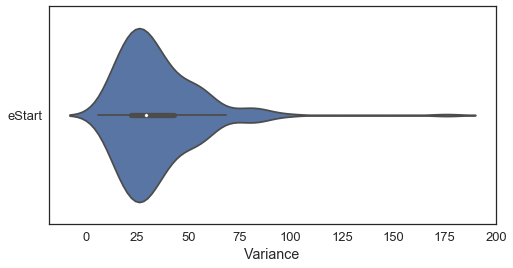

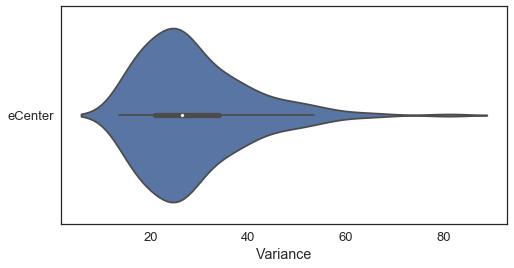

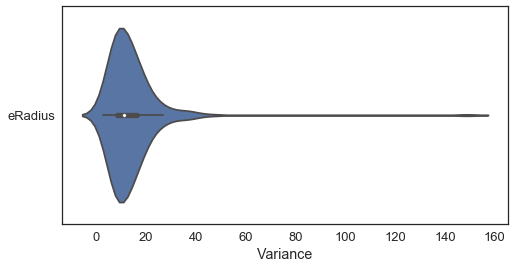

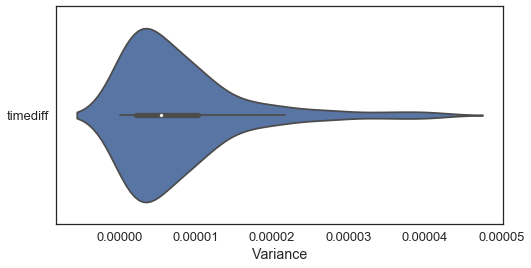

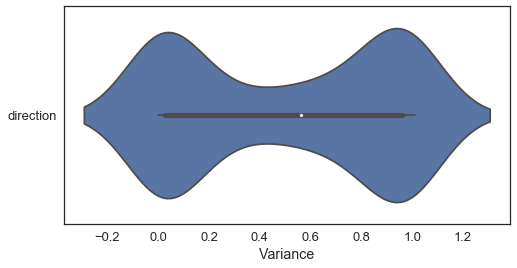

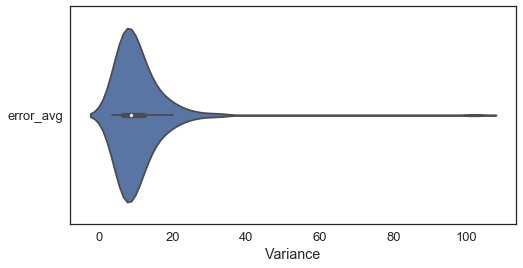

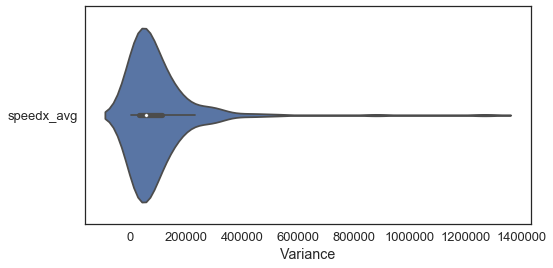

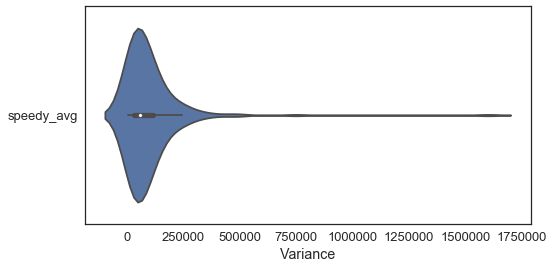

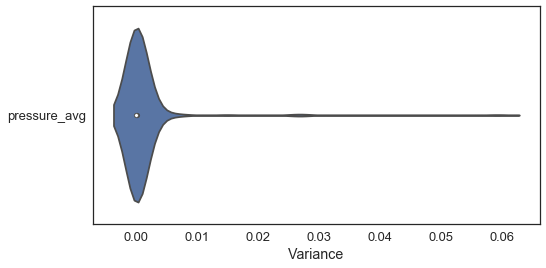

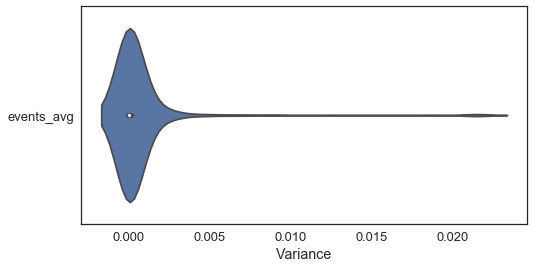

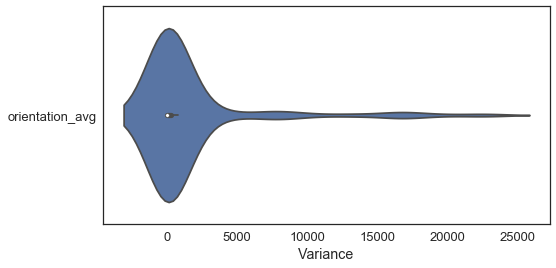

In [434]:
f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_eStart)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_eCenter)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_eRadius)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_timediff)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_direction)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_error_avg)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_speedx_avg)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_speedy_avg)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_pressure_avg)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_events_avg)
plt.xlabel('Variance')
plt.ylabel('')

f, ax = plt.subplots(figsize=(8,4))
_ = sns.violinplot(x='value', y='variable', data=variance_orientation_avg)
plt.xlabel('Variance')
plt.ylabel('')

Most of the feature group variance distributions turned out to be unimodal with long tails. However, the direction feature is clearly bimodal (clockwise vs. anti-clockwise), and the orientation feature group is trimodal. While I am unable to articulate what exactly distinguishes the three groupings of orientation data, it is extremely interesting that people tend to orient their phones in three specific ways while drawing their circles.

### Individual User Crossfilters

In order to address the second half of my question I decided to use crossfilters. Below are two examples: one from Stan, a user with very average data; and one from Daniel, a user with much more aberrant data.

#### Stan:

In [52]:
x = reduced_data.loc[reduced_data['ID'] == 'stan'] #stan -- normal, daniel, less normal   
Crossfilter(x.loc[:, 'eStart':], width=310, height=160)

#### Rafat:

In [442]:
y = reduced_data.loc[reduced_data['ID'] == 'rafat'] #stan -- normal, daniel, less normal   
Crossfilter(y.loc[:, 'eStart':], width=310, height=160)

The Crossfilters make it clear that (a) individual users are not very consistent, and (b) device type is most likely having a large impact on the efficacy of the system. An example of (a) is that Stan draws roughly 50% of his circles in each direction. An example of (b) is that Rafat's phone recorded no pressure and events data at all, whereas Stan's phone did.

### Q4: Do clear clusters of user profiles exist? If so, can they be given meaningful names?

In [287]:
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn.cluster as skc

In [288]:
# To perform hierarchical clustering, the first step is to compute 
# the distance matrix. We will be using the Euclidean distance.
reduced_data_grouped_dist = spd.squareform(spd.pdist(reduced_data_grouped, metric='euclidean'))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



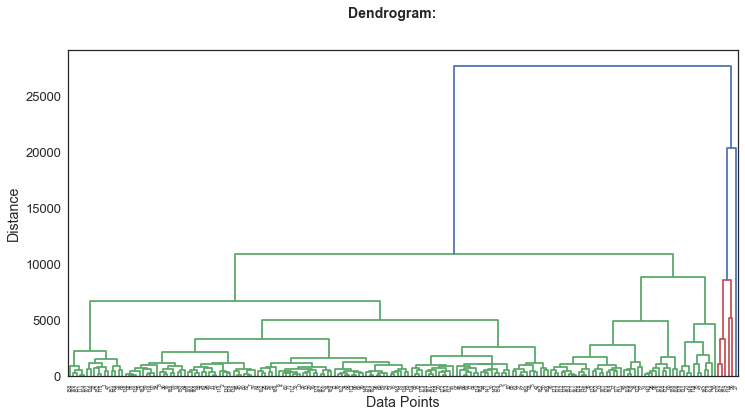

In [289]:
# Perform hierarchical clustering and plot the dendrogram.
Z_xy = sph.linkage(reduced_data_grouped_dist, method='average', optimal_ordering=True)  # obtain the linkage matrix
f, ax = plt.subplots(figsize=(12, 6))
_ = sph.dendrogram(Z_xy)  # plot the linkage matrix as a dendrogram
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram:', 
             fontweight='bold', fontsize=14);

In [290]:
cluster_labels = sph.fcluster(Z_xy, 7500, criterion='distance')
reduced_data_grouped['cluster_label_h'] = cluster_labels
reduced_data_grouped.head(5)

,ID,eStart,eCenter,direction,timediff,eRadius,error_avg,speedx_avg,speedy_avg,pressure_avg,events_avg,orientation_avg,cluster_label_h
0,0,9.827233,8.482578,-0.077778,0.011014,4.436111,8.531729,768.948652,762.643723,0.195753,0.174167,257.896350,1
1,52,4.696519,7.417431,-1.000000,0.018693,2.873805,5.006083,421.322258,400.289953,0.022063,0.040300,79.577412,1
2,53,12.740418,11.978390,0.128571,0.014089,6.546429,10.590667,615.455824,612.881818,1.000000,0.039200,257.140164,1
3,54,15.026445,11.891847,0.683333,0.008481,8.058333,11.590059,1065.675148,1072.142577,1.000000,0.224917,315.681505,1
4,55,12.914999,7.676461,0.442857,0.011259,3.252380,6.310192,754.539824,759.774801,1.000000,0.038480,236.767336,1


In [291]:
reduced_data_grouped.cluster_label_h.unique()

array([1, 2, 3, 6, 5, 4])

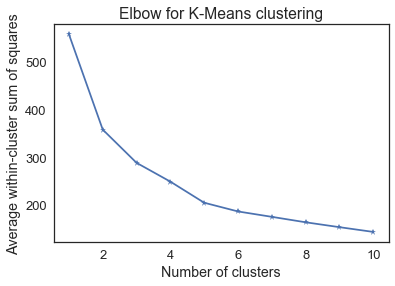

In [292]:
X = reduced_data_grouped  # Using the the dataset of Section 1
K = range(1,11)  # Apply kmeans 1 to 10
kmeans_models = [skc.KMeans(k).fit(X) for k in K]
centroids = [m.cluster_centers_ for m in kmeans_models]
D_k = [spd.cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

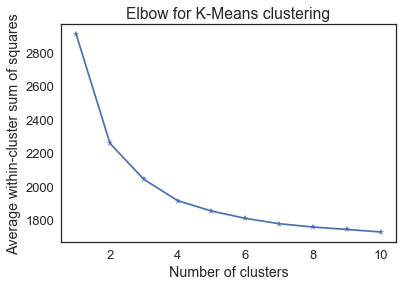

In [293]:
X = all_data.loc[:, 'error1':'orient10']  # Using the the dataset of Section 1
K = range(1,11)  # Apply kmeans 1 to 10
kmeans_models = [skc.KMeans(k).fit(X) for k in K]
centroids = [m.cluster_centers_ for m in kmeans_models]
D_k = [spd.cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

In [294]:
# Perform k-means using the scikit-learn package
kmeans_model = skc.KMeans(n_clusters=5)
kmeans_model.fit(reduced_data_grouped)
reduced_data_grouped['cluster_labels_kmeans'] = kmeans_model.labels_
centroids = kmeans_model.cluster_centers_
reduced_data_grouped.sample(5)

,ID,eStart,eCenter,direction,timediff,eRadius,error_avg,speedx_avg,speedy_avg,pressure_avg,events_avg,orientation_avg,cluster_label_h,cluster_labels_kmeans
85,112,6.886971,7.610836,-0.028571,0.007651,2.901786,5.508708,1079.766173,1131.155860,0.228702,0.278901,255.954117,1,3
109,27,10.186580,6.821347,-0.766667,0.005572,3.105553,6.222945,1421.593239,1414.530733,1.000000,0.072687,285.205719,2,3
93,119,12.007501,10.522285,-1.000000,0.008210,4.716665,7.351733,1122.167880,1131.796443,1.000000,0.041790,48.443380,1,3
74,105,9.477431,8.597706,-1.000000,0.011674,6.199999,7.637275,792.236913,825.155796,1.000000,0.211757,301.129556,1,4
24,71,7.732373,7.875328,-0.485714,0.011899,3.775000,5.423555,678.769982,642.337481,0.204697,0.105111,164.463727,1,4


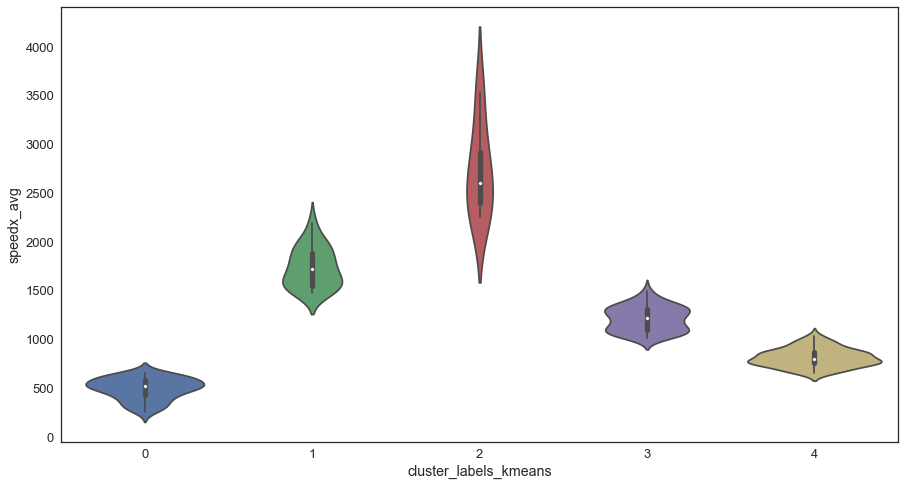

In [309]:
f, ax = plt.subplots(figsize=(15,8))
_ = sns.violinplot(x="cluster_labels_kmeans", y="speedx_avg", data=reduced_data_grouped)

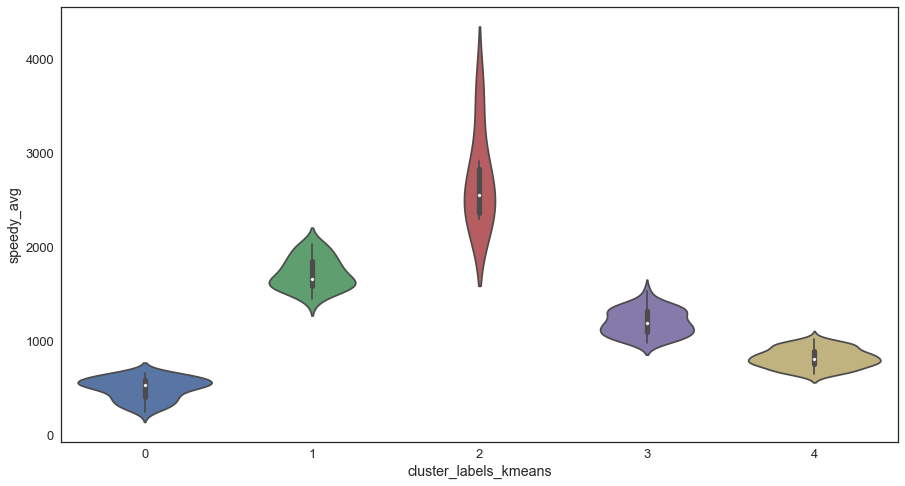

In [308]:
f, ax = plt.subplots(figsize=(15,8))
_ = sns.violinplot(x="cluster_labels_kmeans", y="speedy_avg", data=reduced_data_grouped)

### Q5: How widely (or narrowly) are the user profiles dispersed within the entire 65-dimensional feature space?

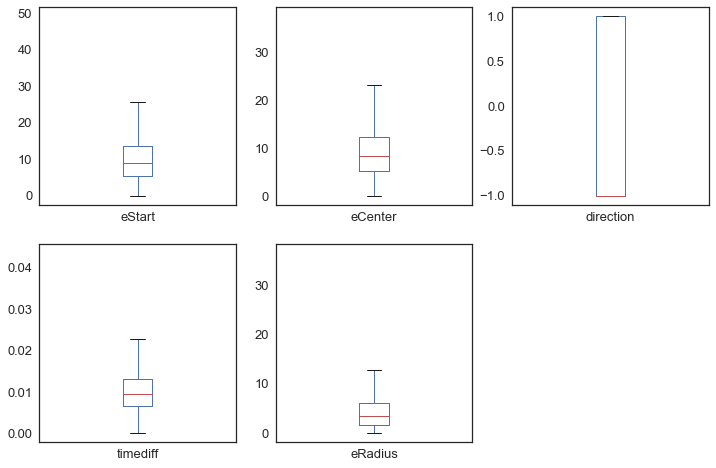

In [285]:
_ = all_data.loc[:, 'eStart':'eRadius'].plot.box(subplots=True, figsize=(12,8), layout=(2,3))

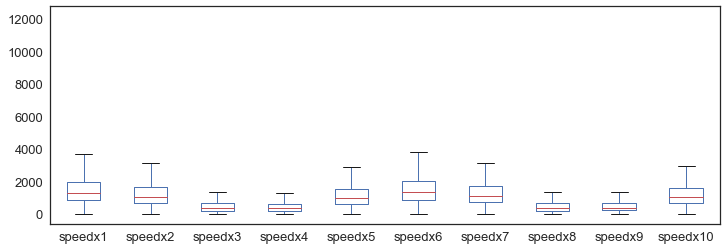

In [267]:
_ = all_data.loc[:, 'speedx1':'speedx10':2].plot.box(figsize=(12,4))

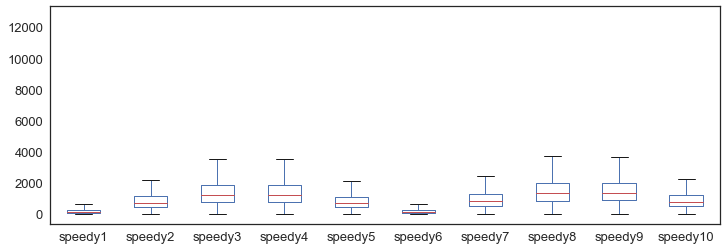

In [268]:
_ = all_data.loc[:, 'speedy1':'speedy10':2].plot.box(figsize=(12,4))

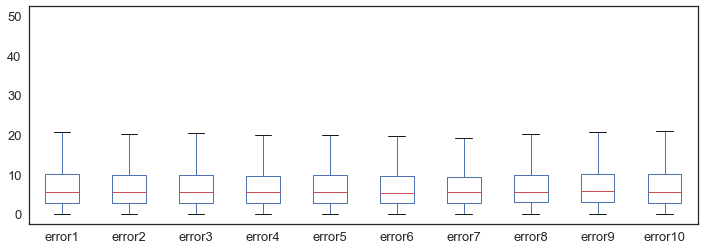

In [266]:
_ = all_data.loc[:, 'error1':'error10'].plot.box(figsize=(12,4))

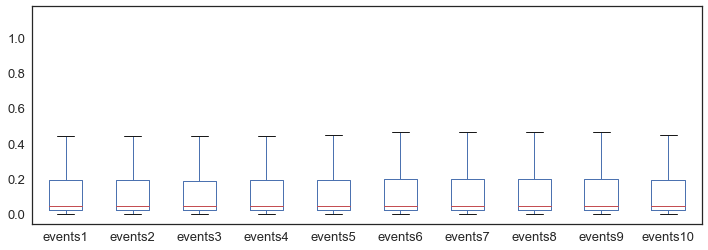

In [263]:
_ = all_data.loc[:, 'events1':'events10'].plot.box(figsize=(12,4))

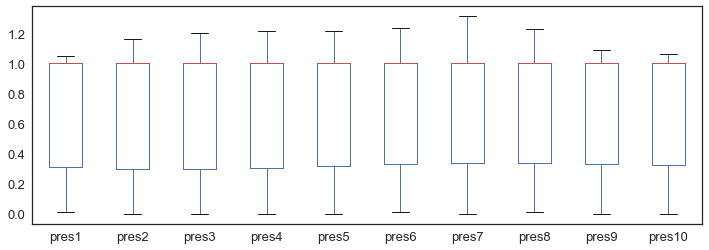

In [264]:
_ = all_data.loc[:, 'pres1':'pres10'].plot.box(figsize=(12,4))

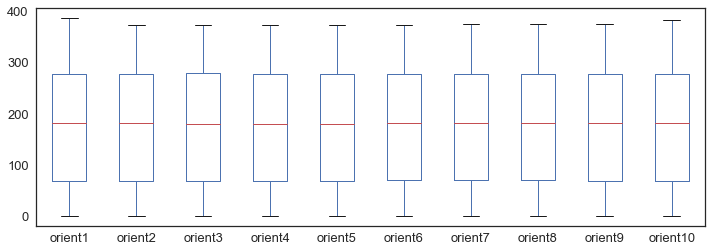

In [265]:
_ = all_data.loc[:, 'orient1':'orient10'].plot.box(figsize=(12,4))

### Q6: Which features or feature groups are most heavily impacted by device type?

In [171]:
dac_index = pd.read_csv('index.csv')
dac_index = dac_index.loc[:, 'name':'reg_file']

In [172]:
device_types = [x[2:] for x in dac_index['reg_file'].str.split('_').values]
device_types = list(map(lambda s: s.replace('.csv',''), map("_".join, device_types)))

In [173]:
dac_index['device_type'] = device_types
dac_index = dac_index.drop(columns=['reg_file'], axis=1)
dac_index = pd.concat([dac_index, dac_index['device_type'].str.split('_', expand=True)], axis=1)

In [174]:
print(len(dac_index['device_type'].unique()))
print(len(dac_index[0].unique()))
print(len(dac_index[1].unique()))

140
140
65


In [175]:
device_dict = dict(zip(dac_index.name, dac_index[1]))

In [176]:
device_type = [device_dict[x] if x in device_dict.keys() else "unknown" for x in reduced_data['ID']]
reduced_data['device_type'] = device_type

In [189]:
reduced_data['device_type_code'] = reduced_data['device_type'].cat.codes

Text(0.5,1,'Feature Correlation Heatmap')

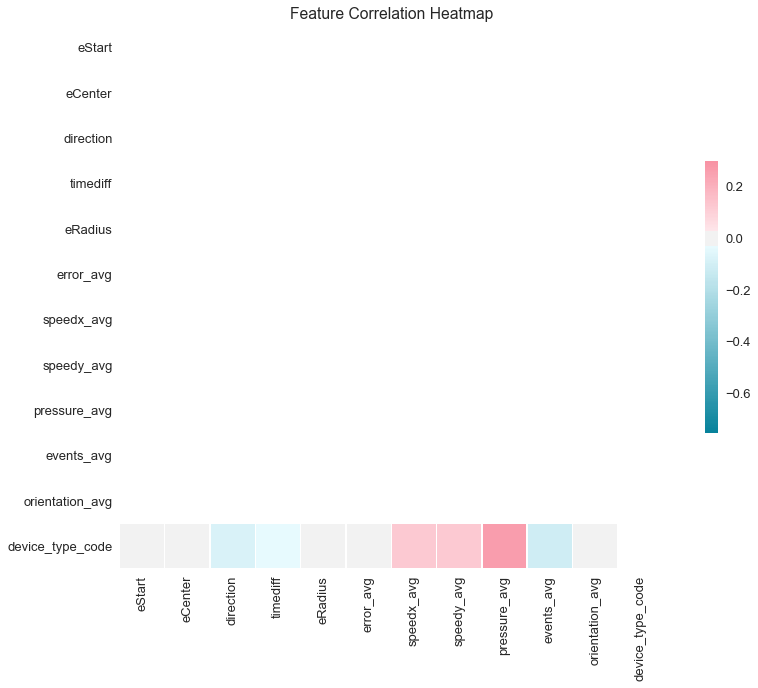

In [192]:
corr4 = reduced_data.corr()
mask = [[True for x in range(12)] for y in range(11)]
mask.append([False if x < 11 else True for x in range(12)])
mask = np.asarray(mask)
sns.set(style='white', color_codes=True, font_scale=1.3)
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, s=99, as_cmap=True)
_ = sns.heatmap(corr4, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Heatmap')

In [193]:
reduced_data['device_type'] = reduced_data['device_type'].astype('category')

ValueError: Could not interpret input 'device_type'

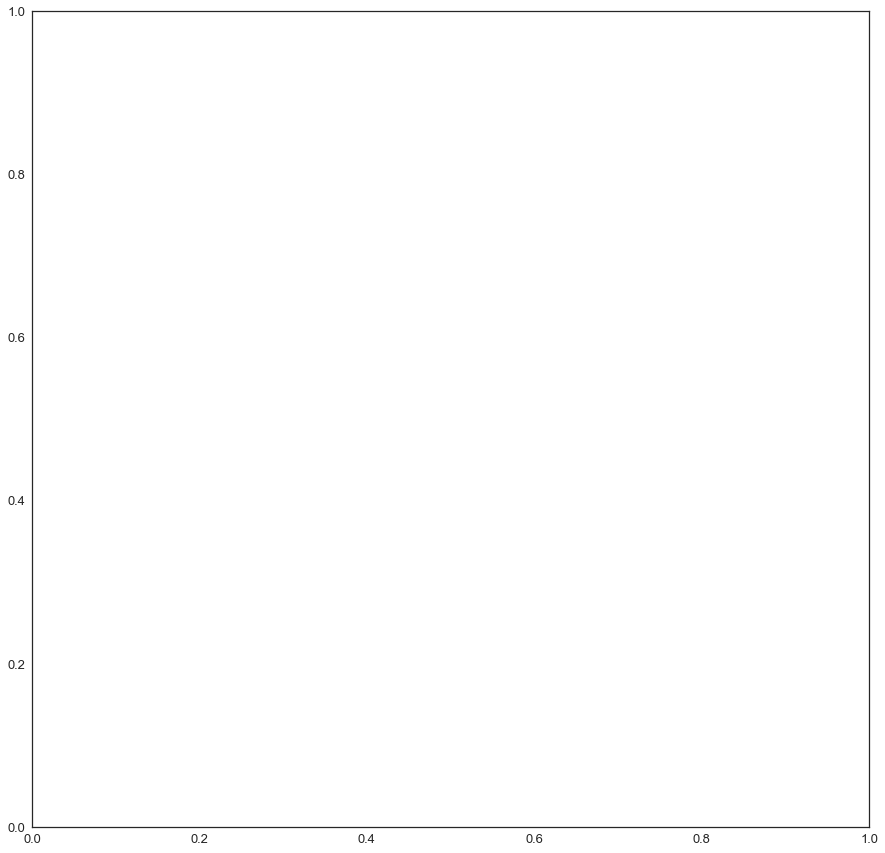

In [435]:
f, ax = plt.subplots(figsize=(15,20))
_ = sns.violinplot(x="pressure_avg", y="device_type", data=reduced_data)

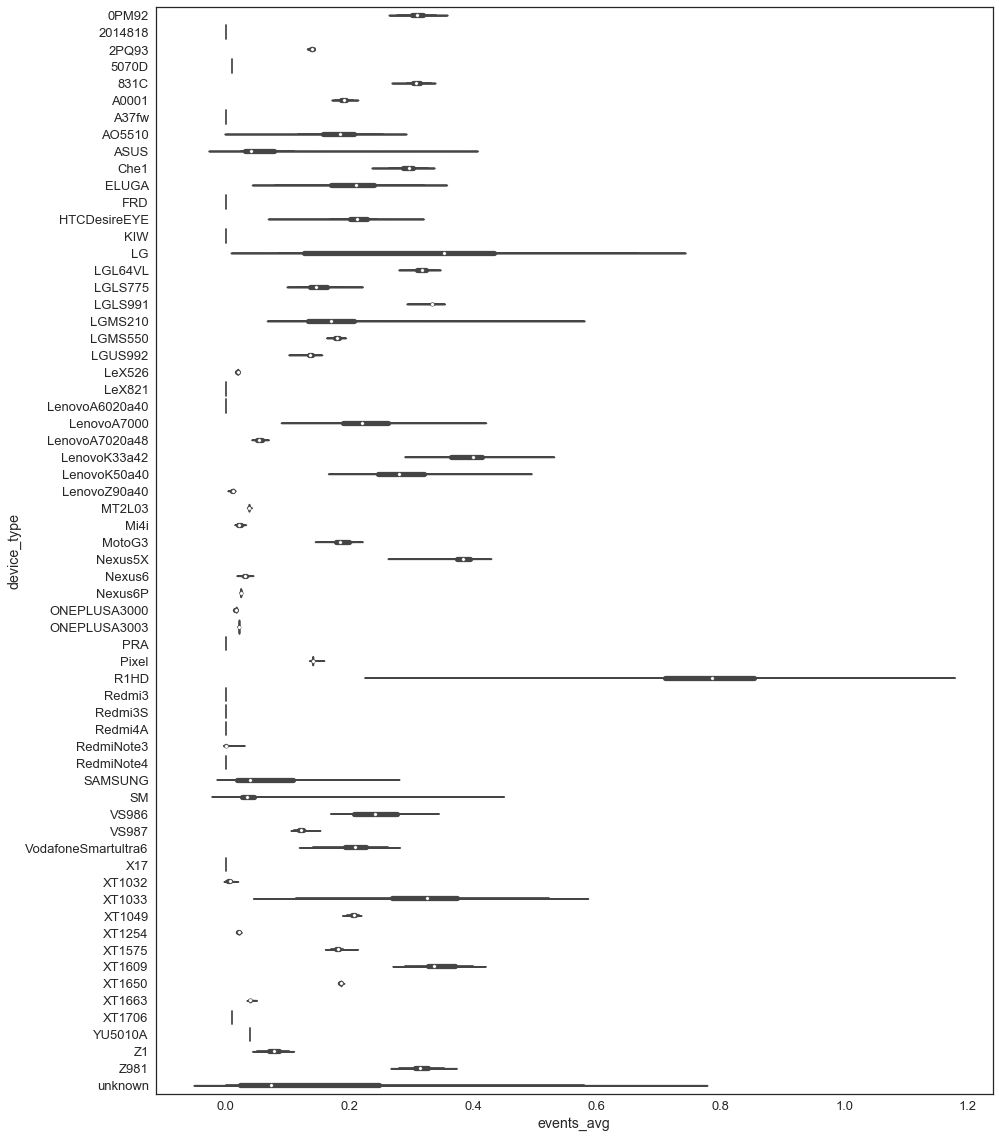

In [195]:
f, ax = plt.subplots(figsize=(15,20))
_ = sns.violinplot(x="events_avg", y="device_type", data=reduced_data)